In [1]:
!pip install -q datasets langchain langchain_openai langchain_deepseek tqdm matplotlib pandas seaborn pyarrow faiss-cpu langchain_community sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.7/418.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7

In [2]:
import os
import json
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import time
from datetime import datetime
import requests
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import TextLoader

In [3]:
!mkdir -p results
!mkdir -p knowledge

# SiliconFlow API setup
API_KEY = "sk-aymackuywttxabaqknbdqgihfceeqwxkvkqnvkmrukdlbkdf"
API_URL = "https://api.siliconflow.cn/v1/chat/completions"
MODEL = "Qwen/QwQ-32B"  # Using Qwen model as suggested

In [4]:
def call_api(prompt, temperature=0.1, max_tokens=512):
    """
    Call the SiliconFlow API with the given prompt
    """
    payload = {
        "model": MODEL,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "stream": False,
        "max_tokens": max_tokens,
        "stop": None,
        "temperature": temperature,
        "top_p": 1,
        "top_k": 50,
        "frequency_penalty": 0.0,
        "n": 1,
        "response_format": {"type": "text"}
    }

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    try:
        response = requests.post(API_URL, json=payload, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        result = response.json()

        # Extract the response text
        return result["choices"][0]["message"]["content"]

    except Exception as e:
        print(f"API call error: {e}")
        if response is not None:
            print(f"Response status: {response.status_code}")
            print(f"Response content: {response.text}")
        return f"ERROR: {str(e)}"

In [5]:
def get_label_text(label):
    """Convert numeric label to text label."""
    mapping = {0: "entailment", 1: "neutral", 2: "contradiction"}
    return mapping.get(label, "unknown")

def get_label_number(label_text):
    """Convert text label to numeric label."""
    mapping = {"entailment": 0, "neutral": 1, "contradiction": 2}
    return mapping.get(label_text.lower(), -1)

def extract_prediction(response):
    """Extract the prediction label from model response."""
    response_lower = response.lower()

    # Look for the last mention of one of the three labels
    last_entailment = response_lower.rfind("entailment")
    last_contradiction = response_lower.rfind("contradiction")
    last_neutral = response_lower.rfind("neutral")

    # Find which label appears last
    last_positions = [
        (last_entailment, "entailment"),
        (last_contradiction, "contradiction"),
        (last_neutral, "neutral")
    ]
    last_positions = [(pos, label) for pos, label in last_positions if pos != -1]

    if last_positions:
        last_positions.sort(reverse=True)  # Sort by position, largest (latest) first
        return last_positions[0][1]

    return "unknown"

def evaluate_accuracy(predictions, ground_truth):
    """Calculate accuracy of predictions."""
    if len(predictions) != len(ground_truth):
        print(f"Warning: Predictions ({len(predictions)}) and ground truth ({len(ground_truth)}) have different lengths")

    # Only consider matching pairs
    pairs = list(zip(predictions, ground_truth))
    correct = sum(get_label_number(p) == g for p, g in pairs if get_label_number(p) != -1)
    total = len(pairs)

    return correct / total if total > 0 else 0

def save_results(technique_name, results, file_prefix="results"):
    """Save results to JSON file."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{file_prefix}/{technique_name}_{timestamp}.json"

    with open(filename, "w") as f:
        json.dump(results, f, indent=2)

    print(f"Results saved to {filename}")
    return filename

def rate_limit_sleep():
    """Sleep for a short time to avoid rate limiting."""
    time.sleep(1)  # Adjust as needed based on API rate limits

In [6]:
def load_anli_data():
    """Load and prepare the ANLI dataset"""
    try:
        print("Loading ANLI dataset via datasets library...")
        from datasets import load_dataset
        dataset = load_dataset("anli")
        df = pd.DataFrame(dataset["test_r1"])
        print(f"Successfully loaded {len(df)} examples from ANLI test_r1")
        return df
    except Exception as e:
        print(f"Dataset loading failed: {e}")

        # Fallback: Create a tiny example dataset for testing
        print("Creating minimal example dataset for testing...")
        example_data = [
            {
                "uid": "example1",
                "premise": "The city of Paris is the capital of France and known for the Eiffel Tower.",
                "hypothesis": "Paris is in France.",
                "label": 0,  # entailment
                "reason": "The premise directly states that Paris is the capital of France."
            },
            {
                "uid": "example2",
                "premise": "The concert was scheduled to start at 8 PM but was delayed due to technical issues.",
                "hypothesis": "The concert was canceled.",
                "label": 1,  # neutral
                "reason": "The premise only mentions a delay, not whether the concert eventually happened."
            },
            {
                "uid": "example3",
                "premise": "All students in the class passed the final exam with scores above 70%.",
                "hypothesis": "Some students failed the exam.",
                "label": 2,  # contradiction
                "reason": "The premise states all students passed, which contradicts the hypothesis."
            }
        ]
        return pd.DataFrame(example_data)

def prepare_balanced_sample(df, n_samples=30, seed=42):
    """Create a balanced sample with equal representation of all labels"""
    random.seed(seed)

    # Get equal samples from each class if possible
    samples_per_class = n_samples // 3
    remaining = n_samples % 3

    # Get samples for each class
    entailment = df[df['label'] == 0].sample(min(samples_per_class + (1 if remaining > 0 else 0), len(df[df['label'] == 0])))
    neutral = df[df['label'] == 1].sample(min(samples_per_class + (1 if remaining > 1 else 0), len(df[df['label'] == 1])))
    contradiction = df[df['label'] == 2].sample(min(samples_per_class, len(df[df['label'] == 2])))

    # Combine and shuffle
    balanced_df = pd.concat([entailment, neutral, contradiction])
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

    print(f"Created balanced sample with {len(balanced_df)} examples")
    print(f"Label distribution: {balanced_df['label'].value_counts().to_dict()}")

    return balanced_df

In [7]:
def run_zero_shot(test_df, max_samples=None):
    """Run zero-shot baseline on test samples."""
    samples = test_df.head(max_samples) if max_samples else test_df
    predictions = []
    detailed_results = []

    zero_shot_prompt = """
    Task: Determine if the hypothesis is entailed by, contradicts, or is neutral to the premise.

    Premise: {premise}
    Hypothesis: {hypothesis}

    Answer with only one of the following: "entailment", "contradiction", or "neutral".
    """

    print(f"Running Zero-Shot baseline on {len(samples)} examples...")

    for i, row in tqdm(samples.iterrows(), total=len(samples)):
        # Format the prompt
        prompt = zero_shot_prompt.format(
            premise=row["premise"],
            hypothesis=row["hypothesis"]
        )

        # Get model response
        response = call_api(prompt)

        if response.startswith("ERROR:"):
            print(f"Error processing example {i}: {response}")
            predictions.append("error")
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": "error",
                "correct": False,
                "error": response,
                "technique": "zero_shot"
            })
        else:
            prediction = extract_prediction(response)

            # Store detailed results
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": prediction,
                "correct": get_label_number(prediction) == row["label"],
                "response": response,
                "technique": "generate_knowledge"
            })

            predictions.append(prediction)

        # Add short delay to avoid rate limiting
        rate_limit_sleep()

    # Calculate accuracy
    ground_truth = [get_label_text(row["label"]) for _, row in samples.iterrows()]
    accuracy = evaluate_accuracy(predictions, ground_truth)

    print(f"Generate Knowledge accuracy: {accuracy:.2%}")

    return predictions, detailed_results, accuracy

In [8]:
def run_chain_of_thought(test_df, max_samples=None):
    """Implement Chain-of-Thought prompting for ANLI."""
    samples = test_df.head(max_samples) if max_samples else test_df
    predictions = []
    detailed_results = []

    cot_prompt = """
    Task: Carefully determine if the hypothesis is entailed by, contradicts, or is neutral to the premise.

    Premise: {premise}
    Hypothesis: {hypothesis}

    Please think step by step:
    1. Identify the key claims in the premise.
    2. Identify the key claims in the hypothesis.
    3. Determine if there are any potential logical traps or ambiguities.
    4. Consider whether the hypothesis necessarily follows from the premise (entailment).
    5. Consider whether the hypothesis contradicts information in the premise (contradiction).
    6. Consider whether the hypothesis is compatible with but not necessarily implied by the premise (neutral).
    7. Make your final judgment.

    After your step-by-step analysis, end with your final answer using exactly one of these labels: "entailment", "contradiction", or "neutral".
    """

    print(f"Running Chain-of-Thought on {len(samples)} examples...")

    for i, row in tqdm(samples.iterrows(), total=len(samples)):
        prompt = cot_prompt.format(
            premise=row["premise"],
            hypothesis=row["hypothesis"]
        )

        response = call_api(prompt, max_tokens=1024)  # Longer response for CoT

        if response.startswith("ERROR:"):
            print(f"Error processing example {i}: {response}")
            predictions.append("error")
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": "error",
                "correct": False,
                "error": response,
                "technique": "chain_of_thought"
            })
        else:
            prediction = extract_prediction(response)

            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": prediction,
                "correct": get_label_number(prediction) == row["label"],
                "response": response,
                "technique": "chain_of_thought"
            })

            predictions.append(prediction)

        # Add short delay to avoid rate limiting
        rate_limit_sleep()

    # Calculate accuracy
    ground_truth = [get_label_text(row["label"]) for _, row in samples.iterrows()]
    accuracy = evaluate_accuracy(predictions, ground_truth)

    print(f"Chain-of-Thought accuracy: {accuracy:.2%}")

    return predictions, detailed_results, accuracy

In [9]:
def run_generate_knowledge(test_df, max_samples=None):
    """Implement Generate Knowledge Prompting for ANLI."""
    samples = test_df.head(max_samples) if max_samples else test_df
    predictions = []
    detailed_results = []

    knowledge_prompt = """
    Task: Determine if the hypothesis is entailed by, contradicts, or is neutral to the premise.

    First, let's establish some key principles about natural language inference and potential adversarial patterns:

    1. Entailment means the hypothesis must necessarily be true if the premise is true.
    2. Contradiction means the hypothesis cannot be true if the premise is true.
    3. Neutral means the hypothesis may or may not be true given the premise.
    4. Adversarial examples often:
       - Use subtle negations
       - Introduce temporal inconsistencies
       - Employ quantifier swapping (all vs. some)
       - Use lexical substitutions that change meaning
       - Include presupposition failures
       - Contain implicatures that are defeasible

    Now, analyze the following:

    Premise: {premise}
    Hypothesis: {hypothesis}

    Based on the principles above, provide your analysis and answer with exactly one of the following: "entailment", "contradiction", or "neutral".
    """

    print(f"Running Generate Knowledge on {len(samples)} examples...")

    for i, row in tqdm(samples.iterrows(), total=len(samples)):
        prompt = knowledge_prompt.format(
            premise=row["premise"],
            hypothesis=row["hypothesis"]
        )

        response = call_api(prompt, max_tokens=1024)

        if response.startswith("ERROR:"):
            print(f"Error processing example {i}: {response}")
            predictions.append("error")
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": "error",
                "correct": False,
                "error": response,
                "technique": "generate_knowledge"
            })
        else:
            prediction = extract_prediction(response)

            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": prediction,
                "correct": get_label_number(prediction) == row["label"],
                "response": response,
                "technique": "generate_knowledge"
            })

            predictions.append(prediction)

        # Add short delay to avoid rate limiting
        rate_limit_sleep()

    # Calculate accuracy
    ground_truth = [get_label_text(row["label"]) for _, row in samples.iterrows()]
    accuracy = evaluate_accuracy(predictions, ground_truth)

    print(f"Generate Knowledge accuracy: {accuracy:.2%}")

    return predictions, detailed_results, accuracy

In [10]:
def run_agent_approach(test_df, max_samples=None):
    """
    Implement an agent-based approach that breaks down the task into subtasks.
    """
    samples = test_df.head(max_samples) if max_samples else test_df
    predictions = []
    detailed_results = []

    agent_prompt = """
    You are an advanced reasoning agent specialized in natural language inference, particularly for adversarial examples.

    TASK: Analyze this natural language inference example:

    Premise: {premise}
    Hypothesis: {hypothesis}

    Please follow these steps:

    Step 1: Use SEMANTIC_PARSER to analyze the premise. Extract key propositions and semantic relationships.
    Step 2: Use SEMANTIC_PARSER to analyze the hypothesis. Extract key propositions and semantic relationships.
    Step 3: Use CONSISTENCY_CHECKER to evaluate logical relations between the premise and hypothesis.
    Step 4: Use ADVERSARIAL_DETECTOR to identify potential adversarial features in this example.
    Step 5: Make your final determination.

    After completing all steps, clearly state your final answer using exactly one of these labels: "entailment", "contradiction", or "neutral".
    """

    print(f"Running Agent approach on {len(samples)} examples...")

    for i, row in tqdm(samples.iterrows(), total=len(samples)):
        prompt = agent_prompt.format(
            premise=row["premise"],
            hypothesis=row["hypothesis"]
        )

        response = call_api(prompt, max_tokens=1536)  # Longer response for agent approach

        if response.startswith("ERROR:"):
            print(f"Error processing example {i}: {response}")
            predictions.append("error")
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": "error",
                "correct": False,
                "error": response,
                "technique": "agent"
            })
        else:
            prediction = extract_prediction(response)

            # Store detailed results
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": prediction,
                "correct": get_label_number(prediction) == row["label"],
                "response": response,
                "technique": "agent"
            })

            predictions.append(prediction)

        # Add short delay to avoid rate limiting
        rate_limit_sleep()

    # Calculate accuracy
    ground_truth = [get_label_text(row["label"]) for _, row in samples.iterrows()]
    accuracy = evaluate_accuracy(predictions, ground_truth)

    print(f"Agent approach accuracy: {accuracy:.2%}")

    return predictions, detailed_results, accuracy

In [11]:
def create_knowledge_base(text_files):
    """Create a knowledge base from a list of text files for RAG."""
    # Initialize document loader and load documents
    documents = []
    for file_path in text_files:
        try:
            loader = TextLoader(file_path)
            documents.extend(loader.load())
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512,
        chunk_overlap=64
    )
    chunks = text_splitter.split_documents(documents)

    # Create vector store
    try:
        # Use a small, fast model for embeddings
        embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
        vector_store = FAISS.from_documents(chunks, embeddings)
        print(f"Successfully created knowledge base with {len(chunks)} chunks")
        return vector_store
    except Exception as e:
        print(f"Error creating vector store: {e}")
        return None

def retrieve_context(vector_store, query, k=3):
    """Retrieve relevant context from the knowledge base for a given query."""
    if vector_store is None:
        print("Vector store is not available")
        return ""

    try:
        # Retrieve relevant documents
        docs = vector_store.similarity_search(query, k=k)

        # Format context
        context = "\n\n".join([doc.page_content for doc in docs])
        return context
    except Exception as e:
        print(f"Error retrieving context: {e}")
        return ""

def run_rag(test_df, knowledge_files=["knowledge/nli_info.txt"], max_samples=None):
    """
    Implement Retrieval Augmented Generation (RAG) for ANLI.
    Uses an external knowledge base to provide relevant context to the model.
    """
    samples = test_df.head(max_samples) if max_samples else test_df
    predictions = []
    detailed_results = []

    # Create knowledge base
    print("Creating knowledge base for RAG...")
    kb = create_knowledge_base(knowledge_files)

    rag_prompt = """
    Task: Determine if the hypothesis is entailed by, contradicts, or is neutral to the premise.

    I'll provide you with some expert knowledge about natural language inference to help with your analysis.

    Expert Knowledge:
    {context}

    Now, analyze the following:

    Premise: {premise}
    Hypothesis: {hypothesis}

    Using the expert knowledge above, provide your analysis and answer with exactly one of the following: "entailment", "contradiction", or "neutral".
    """

    print(f"Running RAG on {len(samples)} examples...")

    for i, row in tqdm(samples.iterrows(), total=len(samples)):
        # Create query from premise and hypothesis
        query = f"natural language inference: {row['premise']} {row['hypothesis']}"

        # Retrieve relevant context
        context = retrieve_context(kb, query)

        # Format the prompt with the retrieved context
        prompt = rag_prompt.format(
            context=context,
            premise=row["premise"],
            hypothesis=row["hypothesis"]
        )

        # Get model response
        response = call_api(prompt, max_tokens=1024)

        if response.startswith("ERROR:"):
            print(f"Error processing example {i}: {response}")
            predictions.append("error")
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": "error",
                "correct": False,
                "error": response,
                "technique": "rag"
            })
        else:
            prediction = extract_prediction(response)

            # Store detailed results
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": prediction,
                "correct": get_label_number(prediction) == row["label"],
                "response": response,
                "technique": "rag",
                "context_used": context[:300] + "..." if len(context) > 300 else context
            })

            predictions.append(prediction)

        # Add short delay to avoid rate limiting
        rate_limit_sleep()

    # Calculate accuracy
    ground_truth = [get_label_text(row["label"]) for _, row in samples.iterrows()]
    accuracy = evaluate_accuracy(predictions, ground_truth)

    print(f"RAG accuracy: {accuracy:.2%}")

    return predictions, detailed_results, accuracy

In [12]:
def run_react(test_df, max_samples=None):
    """
    Implement ReAct (Reasoning + Acting) approach for ANLI.
    This combines reasoning traces with the ability to take "actions" such as
    breaking down the problem, analyzing components, and synthesizing results.
    """
    samples = test_df.head(max_samples) if max_samples else test_df
    predictions = []
    detailed_results = []

    react_prompt = """
    Task: Determine if the hypothesis is entailed by, contradicts, or is neutral to the premise.

    I want you to solve this task following the ReAct framework: Think step by step, take actions when needed, and make a final decision.

    Premise: {premise}
    Hypothesis: {hypothesis}

    Please solve this step by step:

    Thought 1: [Think about the premise and what it states]
    Action 1: [Analyze the key claims in the premise]
    Observation 1: [Summarize your findings about the premise]

    Thought 2: [Think about the hypothesis and what it states]
    Action 2: [Analyze the key claims in the hypothesis]
    Observation 2: [Summarize your findings about the hypothesis]

    Thought 3: [Consider the relationship between the premise and hypothesis]
    Action 3: [Compare the semantic content of both statements]
    Observation 3: [Describe the logical relationship between them]

    Thought 4: [Consider possible traps or edge cases in natural language inference]
    Action 4: [Check for quantifiers, negations, temporal aspects, or other potential complications]
    Observation 4: [Note any important linguistic features that affect the relationship]

    Final Thought: [Determine the relationship based on all previous analysis]
    Final Answer: [Give exactly one of: "entailment", "contradiction", or "neutral"]
    """

    print(f"Running ReAct on {len(samples)} examples...")

    for i, row in tqdm(samples.iterrows(), total=len(samples)):
        prompt = react_prompt.format(
            premise=row["premise"],
            hypothesis=row["hypothesis"]
        )

        response = call_api(prompt, max_tokens=1536)  # Longer response for ReAct

        if response.startswith("ERROR:"):
            print(f"Error processing example {i}: {response}")
            predictions.append("error")
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": "error",
                "correct": False,
                "error": response,
                "technique": "react"
            })
        else:
            # Extract the prediction - with ReAct, we need to look for the Final Answer specifically
            prediction_match = re.search(r"Final Answer:.*?(entailment|contradiction|neutral)", response, re.IGNORECASE)

            if prediction_match:
                prediction = prediction_match.group(1).lower()
            else:
                # Fall back to the regular extraction if no Final Answer is found
                prediction = extract_prediction(response)

            # Store detailed results
            detailed_results.append({
                "premise": row["premise"],
                "hypothesis": row["hypothesis"],
                "ground_truth": get_label_text(row["label"]),
                "prediction": prediction,
                "correct": get_label_number(prediction) == row["label"],
                "response": response,
                "technique": "react"
            })

            predictions.append(prediction)

        # Add short delay to avoid rate limiting
        rate_limit_sleep()

    # Calculate accuracy
    ground_truth = [get_label_text(row["label"]) for _, row in samples.iterrows()]
    accuracy = evaluate_accuracy(predictions, ground_truth)

    print(f"ReAct accuracy: {accuracy:.2%}")

    return predictions, detailed_results, accuracy

In [13]:
def analyze_results(detailed_results, technique_name):
    """Analyze the detailed results for a single technique."""
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(detailed_results)

    # Overall accuracy
    accuracy = df["correct"].mean()
    print(f"\n{technique_name} - Overall accuracy: {accuracy:.2%}")

    # Accuracy by ground truth label
    print("\nAccuracy by ground truth label:")
    label_accuracy = df.groupby("ground_truth")["correct"].mean()
    print(label_accuracy)

    # Confusion matrix
    print("\nConfusion matrix (counts):")
    conf_matrix = pd.crosstab(df["ground_truth"], df["prediction"])
    print(conf_matrix)

    # Normalized confusion matrix
    print("\nConfusion matrix (normalized by row):")
    norm_conf_matrix = pd.crosstab(df["ground_truth"], df["prediction"], normalize="index")
    print(norm_conf_matrix)

    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(norm_conf_matrix, annot=True, fmt=".2%", cmap="Blues")
    plt.title(f"Confusion Matrix for {technique_name}")
    plt.ylabel("Ground Truth")
    plt.xlabel("Prediction")
    plt.tight_layout()
    plt.savefig(f"results/{technique_name}_confusion_matrix.png")
    print(f"Confusion matrix saved to results/{technique_name}_confusion_matrix.png")

    # Find examples of incorrect predictions
    incorrect = df[~df["correct"]]
    print(f"\nNumber of incorrect predictions: {len(incorrect)} ({len(incorrect)/len(df):.2%})")

    return df

In [14]:
def compare_techniques(results_dict):
    """Compare results from different techniques."""
    # Create comparison DataFrame
    comparison = []

    for technique, results in results_dict.items():
        df = pd.DataFrame(results)

        # Calculate overall accuracy
        accuracy = df["correct"].mean()

        # Calculate accuracy by label
        label_accuracies = df.groupby("ground_truth")["correct"].mean().to_dict()

        # Add to comparison
        comparison.append({
            "technique": technique,
            "overall_accuracy": accuracy,
            **{f"accuracy_{label}": acc for label, acc in label_accuracies.items()}
        })

    comparison_df = pd.DataFrame(comparison)

    # Display comparison
    print("\nTechnique Comparison:")
    print(comparison_df)

    # Save comparison
    comparison_df.to_csv("results/technique_comparison.csv", index=False)
    print("Technique comparison saved to results/technique_comparison.csv")

    # Visualize comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x="technique", y="overall_accuracy", data=comparison_df)
    plt.title("Accuracy Comparison Across Techniques")
    plt.ylabel("Accuracy")
    plt.xlabel("Technique")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("results/technique_comparison.png")
    print("Comparison chart saved to results/technique_comparison.png")

    # Create label-specific comparison chart
    plt.figure(figsize=(14, 6))

    # Reshape data for grouped bar chart
    plot_data = []
    for _, row in comparison_df.iterrows():
        technique = row["technique"]
        for label in ["entailment", "neutral", "contradiction"]:
            if f"accuracy_{label}" in row:
                plot_data.append({
                    "technique": technique,
                    "label": label,
                    "accuracy": row[f"accuracy_{label}"]
                })

    plot_df = pd.DataFrame(plot_data)

    # Create grouped bar chart
    sns.barplot(x="technique", y="accuracy", hue="label", data=plot_df)
    plt.title("Accuracy by Label Across Techniques")
    plt.ylabel("Accuracy")
    plt.xlabel("Technique")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(title="Label")
    plt.tight_layout()
    plt.savefig("results/technique_comparison_by_label.png")
    print("Label-specific comparison chart saved to results/technique_comparison_by_label.png")

    return comparison_df

In [15]:
def find_interesting_cases(results_dict, test_df):
    """Find interesting cases for analysis in the report."""
    case_categories = {
        "high_disagreement": [],
        "all_correct": [],
        "all_wrong": [],
        "agent_only_correct": [],
        "agent_only_wrong": []
    }

    # Prepare a unified view of predictions across techniques
    unified_predictions = {}
    for technique, results in results_dict.items():
        for i, result in enumerate(results):
            if i not in unified_predictions:
                unified_predictions[i] = {
                    "premise": result["premise"],
                    "hypothesis": result["hypothesis"],
                    "ground_truth": result["ground_truth"],
                    "predictions": {}
                }
            unified_predictions[i]["predictions"][technique] = {
                "prediction": result["prediction"],
                "correct": result["correct"]
            }

    # Identify interesting cases
    for i, case in unified_predictions.items():
        # Count distinct predictions
        predictions = [case["predictions"][t]["prediction"] for t in results_dict.keys()
                       if t in case["predictions"] and case["predictions"][t]["prediction"] not in ["error", "unknown"]]
        distinct_predictions = len(set(predictions))

        # Count correct predictions
        correct_predictions = sum(case["predictions"][t]["correct"] for t in results_dict.keys() if t in case["predictions"])

        # Case 1: High disagreement (at least 3 different predictions)
        if distinct_predictions >= 3:
            case_categories["high_disagreement"].append(i)

        # Case 2: All techniques correct
        if correct_predictions == len(results_dict):
            case_categories["all_correct"].append(i)

        # Case 3: All techniques wrong
        if correct_predictions == 0:
            case_categories["all_wrong"].append(i)

        # Case 4: Only agent correct
        if ("agent" in results_dict and i < len(results_dict["agent"]) and
            case["predictions"]["agent"]["correct"] and
            sum(case["predictions"][t]["correct"] for t in results_dict.keys() if t != "agent" and t in case["predictions"]) == 0):
            case_categories["agent_only_correct"].append(i)

        # Case 5: Only agent wrong
        if ("agent" in results_dict and i < len(results_dict["agent"]) and
            not case["predictions"]["agent"]["correct"] and
            sum(case["predictions"][t]["correct"] for t in results_dict.keys() if t != "agent" and t in case["predictions"]) == len(results_dict) - 1):
            case_categories["agent_only_wrong"].append(i)

    # Select a few examples from each category
    selected_cases = {}
    for category, indices in case_categories.items():
        if indices:
            # Select up to 3 examples from each category
            selected = random.sample(indices, min(3, len(indices)))
            selected_cases[category] = [unified_predictions[i] for i in selected]

    # Save selected cases
    with open("results/interesting_cases.json", "w") as f:
        json.dump(selected_cases, f, indent=2)
    print(f"Interesting cases saved to results/interesting_cases.json")

    # Print summary of selected cases
    print("\nInteresting Cases Summary:")
    for category, cases in selected_cases.items():
        print(f"- {category}: {len(cases)} examples")

    return selected_cases

In [16]:
def run_experiment(reduced_sample_size=200):
    """Run the complete experiment with all techniques."""
    # Load dataset
    anli_df = load_anli_data()

    if anli_df is None:
        print("Failed to load dataset. Exiting.")
        return None, None, None

    # Create balanced test dataframe
    test_df = prepare_balanced_sample(anli_df, n_samples=reduced_sample_size)

    # Create small test set for verification
    small_test_df = test_df.head(3)
    print(f"\nCreated small test set with {len(small_test_df)} examples for verification")

    # Test API connection
    print("\n===== TESTING API CONNECTION =====\n")
    try:
        test_prompt = "What is natural language inference?"
        test_response = call_api(test_prompt)
        if test_response.startswith("ERROR:"):
            print(f"API connection failed: {test_response}")
            print("Please check your API key and try again.")
            return None, None, None
        else:
            print(f"API connection successful!")
            print(f"Sample response: {test_response[:100]}...")
    except Exception as e:
        print(f"API connection failed: {e}")
        return None, None, None

    # Test with a single example
    print("\n===== TESTING END-TO-END FUNCTIONALITY =====\n")
    try:
        test_row = small_test_df.iloc[0]
        test_prompt = f"""
        Task: Determine if the hypothesis is entailed by, contradicts, or is neutral to the premise.

        Premise: {test_row["premise"]}
        Hypothesis: {test_row["hypothesis"]}

        Answer with only one of the following: "entailment", "contradiction", or "neutral".
        """
        test_response = call_api(test_prompt)
        if test_response.startswith("ERROR:"):
            print(f"End-to-end test failed: {test_response}")
            return None, None, None
        else:
            prediction = extract_prediction(test_response)
            print(f"End-to-end test successful!")
            print(f"  Premise: {test_row['premise'][:50]}...")
            print(f"  Hypothesis: {test_row['hypothesis'][:50]}...")
            print(f"  Ground truth: {get_label_text(test_row['label'])}")
            print(f"  Prediction: {prediction}")
    except Exception as e:
        print(f"End-to-end test failed: {e}")
        return None, None, None

    print("\n===== ALL TESTS PASSED, PROCEEDING WITH EXPERIMENT =====\n")

    # Results dictionary to store all technique results
    all_results = {}

    # 1. Run Zero-Shot Baseline
    print("\n===== RUNNING ZERO-SHOT BASELINE =====\n")
    _, zero_shot_results, zero_shot_acc = run_zero_shot(test_df)
    save_results("zero_shot", zero_shot_results)
    all_results["zero_shot"] = zero_shot_results
    analyze_results(zero_shot_results, "zero_shot")

    # 2. Run Chain-of-Thought
    print("\n===== RUNNING CHAIN-OF-THOUGHT =====\n")
    _, cot_results, cot_acc = run_chain_of_thought(test_df)
    save_results("chain_of_thought", cot_results)
    all_results["chain_of_thought"] = cot_results
    analyze_results(cot_results, "chain_of_thought")

    # 3. Run Generate Knowledge
    print("\n===== RUNNING GENERATE KNOWLEDGE =====\n")
    _, knowledge_results, knowledge_acc = run_generate_knowledge(test_df)
    save_results("generate_knowledge", knowledge_results)
    all_results["generate_knowledge"] = knowledge_results
    analyze_results(knowledge_results, "generate_knowledge")

    # Compare results so far
    comparison_df_initial = compare_techniques({
        "zero_shot": zero_shot_results,
        "chain_of_thought": cot_results,
        "generate_knowledge": knowledge_results
    })

    # 4. Run Agent Approach
    print("\n===== RUNNING AGENT APPROACH =====\n")
    _, agent_results, agent_acc = run_agent_approach(test_df)
    save_results("agent", agent_results)
    all_results["agent"] = agent_results
    analyze_results(agent_results, "agent")

    # 5. Run RAG Approach
    print("\n===== RUNNING RAG APPROACH =====\n")

    # Create a temporary knowledge file with NLI information
    with open("knowledge/nli_info.txt", "w") as f:
        f.write('''
Natural Language Inference (NLI) is a task where the goal is to determine if a hypothesis is entailed by, contradicts, or is neutral to a premise.

Entailment: The hypothesis necessarily follows from the premise. If the premise is true, the hypothesis must also be true.
Example: Premise: "All cats are mammals." Hypothesis: "My pet cat is a mammal." This is an entailment because if all cats are mammals, then any specific cat must be a mammal.

Contradiction: The hypothesis contradicts the premise. If the premise is true, the hypothesis must be false.
Example: Premise: "All cats are mammals." Hypothesis: "My pet cat is a reptile." This is a contradiction because no cat can be a reptile if all cats are mammals.

Neutral: The hypothesis could be true or false given the premise. The premise doesn't provide enough information to determine.
Example: Premise: "All cats are mammals." Hypothesis: "My pet is a mammal." This is neutral because the pet could be a cat (making the hypothesis true) or some other mammal, or not a mammal at all.

Common pitfalls in NLI:
1. Lexical overlap traps: High word overlap doesn't necessarily mean entailment.
2. Negation: Negation often indicates contradiction but not always.
3. Hypernyms/Hyponyms: Category relationships can be tricky (animal vs. dog vs. poodle).
4. Numerical reasoning: "Some" vs. "all" vs. "none" require careful quantifier analysis.
5. Temporal reasoning: Tense and time expressions can change relationships.
6. Presupposition: Some statements assume other facts are true.

Adversarial examples in NLI often:
1. Use subtle negations
2. Swap quantifiers (all, some, none)
3. Use lexical substitutions that change meaning
4. Introduce ambiguity
5. Require world knowledge not present in the premise
        ''')

    _, rag_results, rag_acc = run_rag(test_df, knowledge_files=["knowledge/nli_info.txt"])
    save_results("rag", rag_results)
    all_results["rag"] = rag_results
    analyze_results(rag_results, "rag")

    # 6. Run ReAct Approach
    print("\n===== RUNNING REACT APPROACH =====\n")
    _, react_results, react_acc = run_react(test_df)
    save_results("react", react_results)
    all_results["react"] = react_results
    analyze_results(react_results, "react")

    # Final comparison of all techniques
    comparison_df = compare_techniques(all_results)

    # Find interesting cases for the report
    interesting_cases = find_interesting_cases(all_results, test_df)

    print("\n===== EXPERIMENT COMPLETED =====\n")
    print("Summary of accuracy by technique:")
    for technique, results in all_results.items():
        df = pd.DataFrame(results)
        accuracy = df["correct"].mean()
        print(f"{technique}: {accuracy:.2%}")

    return all_results, comparison_df, interesting_cases

Loading ANLI dataset via datasets library...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

train_r1-00000-of-00001.parquet:   0%|          | 0.00/3.14M [00:00<?, ?B/s]

dev_r1-00000-of-00001.parquet:   0%|          | 0.00/351k [00:00<?, ?B/s]

test_r1-00000-of-00001.parquet:   0%|          | 0.00/353k [00:00<?, ?B/s]

train_r2-00000-of-00001.parquet:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

dev_r2-00000-of-00001.parquet:   0%|          | 0.00/351k [00:00<?, ?B/s]

test_r2-00000-of-00001.parquet:   0%|          | 0.00/362k [00:00<?, ?B/s]

train_r3-00000-of-00001.parquet:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

dev_r3-00000-of-00001.parquet:   0%|          | 0.00/434k [00:00<?, ?B/s]

test_r3-00000-of-00001.parquet:   0%|          | 0.00/435k [00:00<?, ?B/s]

Generating train_r1 split:   0%|          | 0/16946 [00:00<?, ? examples/s]

Generating dev_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r2 split:   0%|          | 0/45460 [00:00<?, ? examples/s]

Generating dev_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_r2 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_r3 split:   0%|          | 0/100459 [00:00<?, ? examples/s]

Generating dev_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test_r3 split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Successfully loaded 1000 examples from ANLI test_r1
Created balanced sample with 100 examples
Label distribution: {0: 34, 1: 33, 2: 33}

Created small test set with 3 examples for verification

===== TESTING API CONNECTION =====

API connection successful!
Sample response: ...

===== TESTING END-TO-END FUNCTIONALITY =====

End-to-end test successful!
  Premise: "Make America Great Again", abbreviated to MAGA, i...
  Hypothesis: Donald Trump will be elected President in 2020....
  Ground truth: neutral
  Prediction: neutral

===== ALL TESTS PASSED, PROCEEDING WITH EXPERIMENT =====


===== RUNNING ZERO-SHOT BASELINE =====

Running Zero-Shot baseline on 100 examples...


  0%|          | 0/100 [00:00<?, ?it/s]

Generate Knowledge accuracy: 0.00%
Results saved to results/zero_shot_20250326_084532.json

zero_shot - Overall accuracy: 54.00%

Accuracy by ground truth label:
ground_truth
contradiction    0.424242
entailment       0.647059
neutral          0.545455
Name: correct, dtype: float64

Confusion matrix (counts):
prediction     contradiction  entailment  neutral  unknown
ground_truth                                              
contradiction             14           1        2       16
entailment                 1          22        0       11
neutral                    1           1       18       13

Confusion matrix (normalized by row):
prediction     contradiction  entailment   neutral   unknown
ground_truth                                                
contradiction       0.424242    0.030303  0.060606  0.484848
entailment          0.029412    0.647059  0.000000  0.323529
neutral             0.030303    0.030303  0.545455  0.393939
Confusion matrix saved to results/zero_shot_confus

  0%|          | 0/100 [00:00<?, ?it/s]

Chain-of-Thought accuracy: 0.00%
Results saved to results/chain_of_thought_20250326_100854.json

chain_of_thought - Overall accuracy: 62.00%

Accuracy by ground truth label:
ground_truth
contradiction    0.636364
entailment       0.558824
neutral          0.666667
Name: correct, dtype: float64

Confusion matrix (counts):
prediction     contradiction  entailment  neutral  unknown
ground_truth                                              
contradiction             21           0        3        9
entailment                 1          19        4       10
neutral                    2           2       22        7

Confusion matrix (normalized by row):
prediction     contradiction  entailment   neutral   unknown
ground_truth                                                
contradiction       0.636364    0.000000  0.090909  0.272727
entailment          0.029412    0.558824  0.117647  0.294118
neutral             0.060606    0.060606  0.666667  0.212121
Confusion matrix saved to results/chai

  0%|          | 0/100 [00:00<?, ?it/s]

Generate Knowledge accuracy: 0.00%
Results saved to results/generate_knowledge_20250326_110708.json

generate_knowledge - Overall accuracy: 70.00%

Accuracy by ground truth label:
ground_truth
contradiction    0.666667
entailment       0.705882
neutral          0.727273
Name: correct, dtype: float64

Confusion matrix (counts):
prediction     contradiction  entailment  neutral  unknown
ground_truth                                              
contradiction             22           1        4        6
entailment                 2          24        0        8
neutral                    1           1       24        7

Confusion matrix (normalized by row):
prediction     contradiction  entailment   neutral   unknown
ground_truth                                                
contradiction       0.666667    0.030303  0.121212  0.181818
entailment          0.058824    0.705882  0.000000  0.235294
neutral             0.030303    0.030303  0.727273  0.212121
Confusion matrix saved to result

  0%|          | 0/100 [00:00<?, ?it/s]

Agent approach accuracy: 0.00%
Results saved to results/agent_20250326_123605.json

agent - Overall accuracy: 76.00%

Accuracy by ground truth label:
ground_truth
contradiction    0.848485
entailment       0.794118
neutral          0.636364
Name: correct, dtype: float64

Confusion matrix (counts):
prediction     contradiction  entailment  neutral  unknown
ground_truth                                              
contradiction             28           1        2        2
entailment                 2          27        0        5
neutral                    5           2       21        5

Confusion matrix (normalized by row):
prediction     contradiction  entailment   neutral   unknown
ground_truth                                                
contradiction       0.848485    0.030303  0.060606  0.060606
entailment          0.058824    0.794118  0.000000  0.147059
neutral             0.151515    0.060606  0.636364  0.151515
Confusion matrix saved to results/agent_confusion_matrix.png



<ipython-input-11-61e9063a6154>:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Successfully created knowledge base with 5 chunks
Running RAG on 100 examples...


  0%|          | 0/100 [00:00<?, ?it/s]

RAG accuracy: 0.00%
Results saved to results/rag_20250326_132807.json

rag - Overall accuracy: 75.00%

Accuracy by ground truth label:
ground_truth
contradiction    0.666667
entailment       0.794118
neutral          0.787879
Name: correct, dtype: float64

Confusion matrix (counts):
prediction     contradiction  entailment  neutral  unknown
ground_truth                                              
contradiction             22           1        6        4
entailment                 3          27        1        3
neutral                    3           2       26        2

Confusion matrix (normalized by row):
prediction     contradiction  entailment   neutral   unknown
ground_truth                                                
contradiction       0.666667    0.030303  0.181818  0.121212
entailment          0.088235    0.794118  0.029412  0.088235
neutral             0.090909    0.060606  0.787879  0.060606
Confusion matrix saved to results/rag_confusion_matrix.png

Number of incorre

  0%|          | 0/100 [00:00<?, ?it/s]

ReAct accuracy: 0.00%
Results saved to results/react_20250326_145125.json

react - Overall accuracy: 80.00%

Accuracy by ground truth label:
ground_truth
contradiction    0.818182
entailment       0.852941
neutral          0.727273
Name: correct, dtype: float64

Confusion matrix (counts):
prediction     contradiction  entailment  neutral  unknown
ground_truth                                              
contradiction             27           2        2        2
entailment                 2          29        1        2
neutral                    5           3       24        1

Confusion matrix (normalized by row):
prediction     contradiction  entailment   neutral   unknown
ground_truth                                                
contradiction       0.818182    0.060606  0.060606  0.060606
entailment          0.058824    0.852941  0.029412  0.058824
neutral             0.151515    0.090909  0.727273  0.030303
Confusion matrix saved to results/react_confusion_matrix.png

Number of

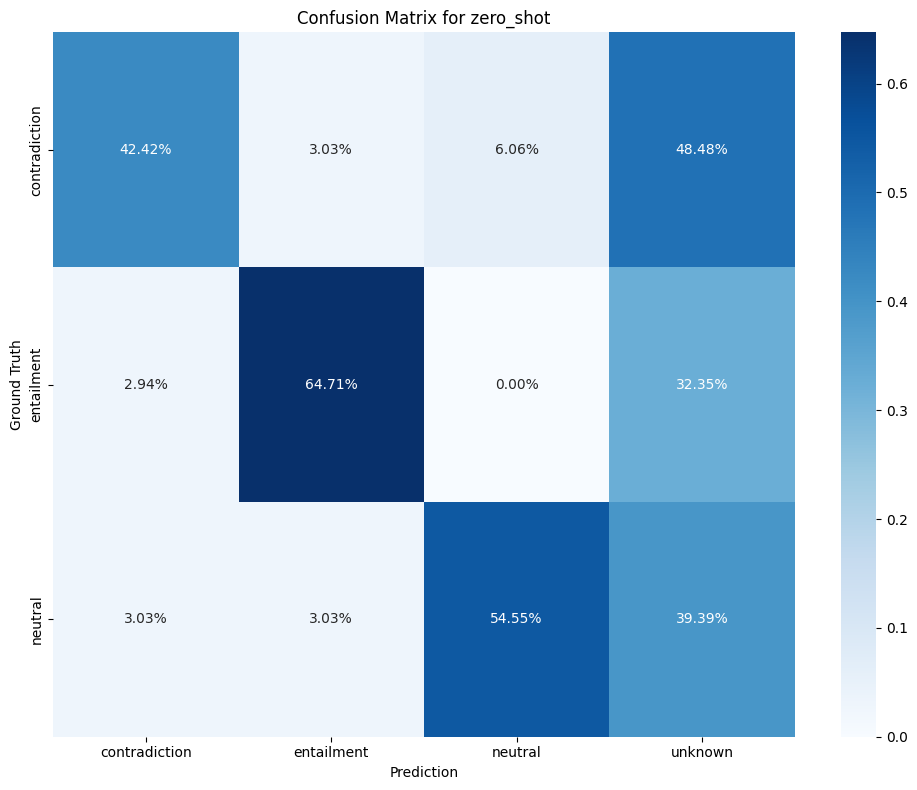

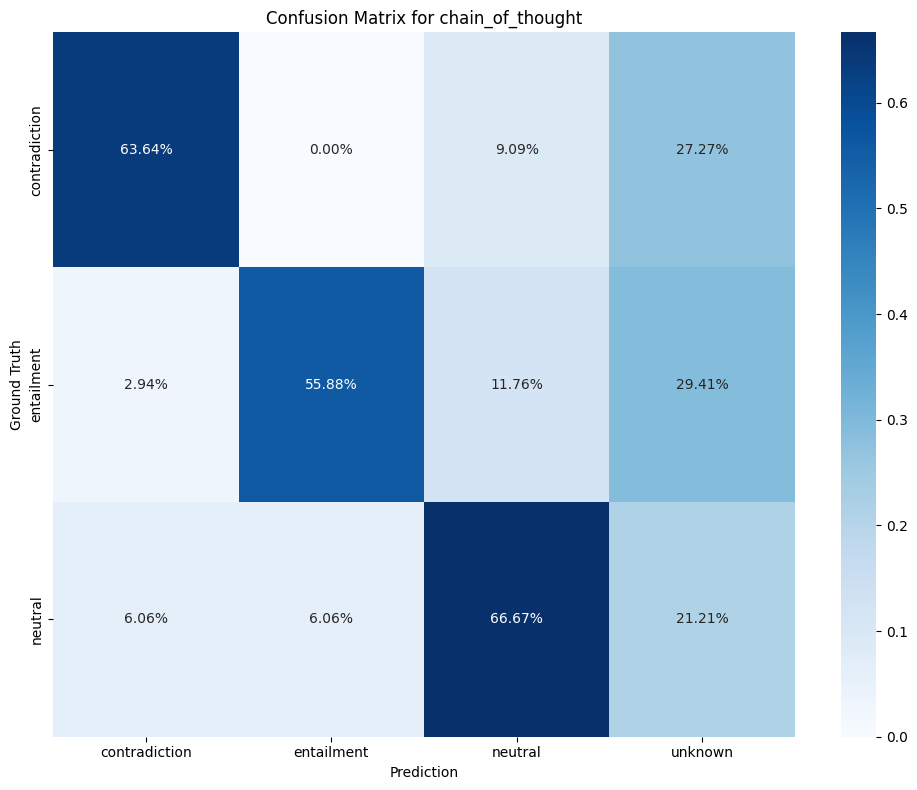

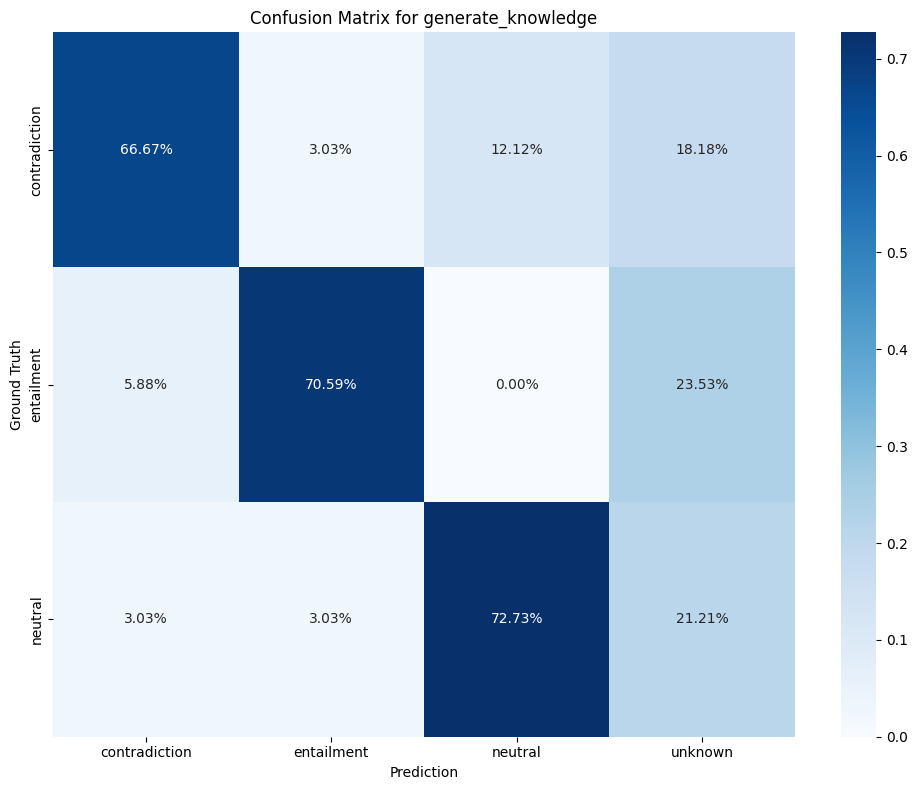

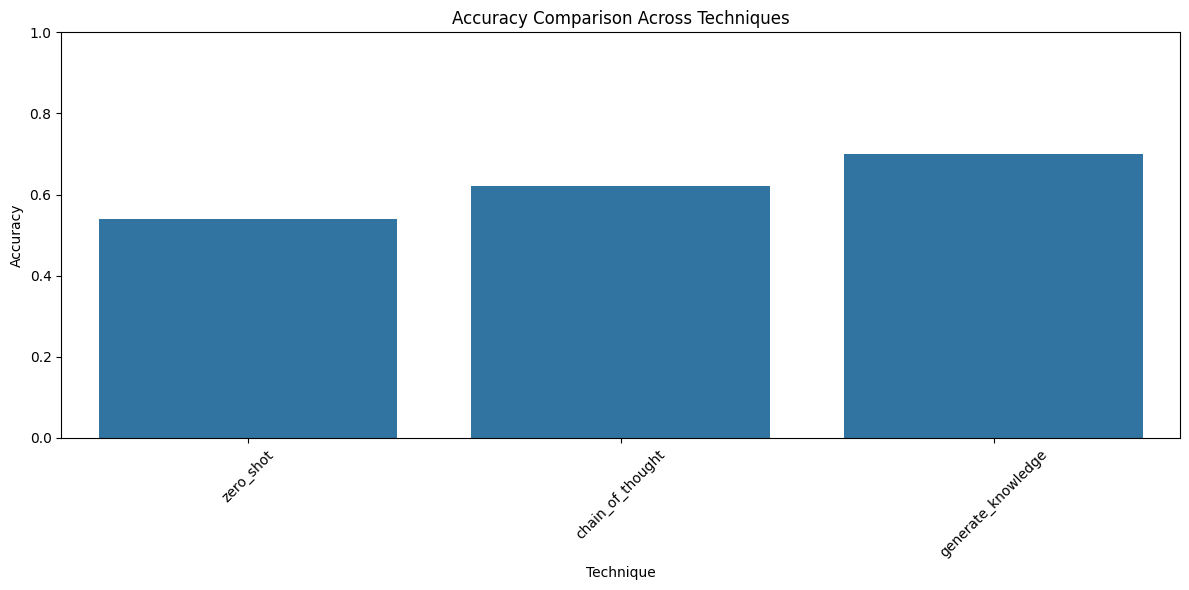

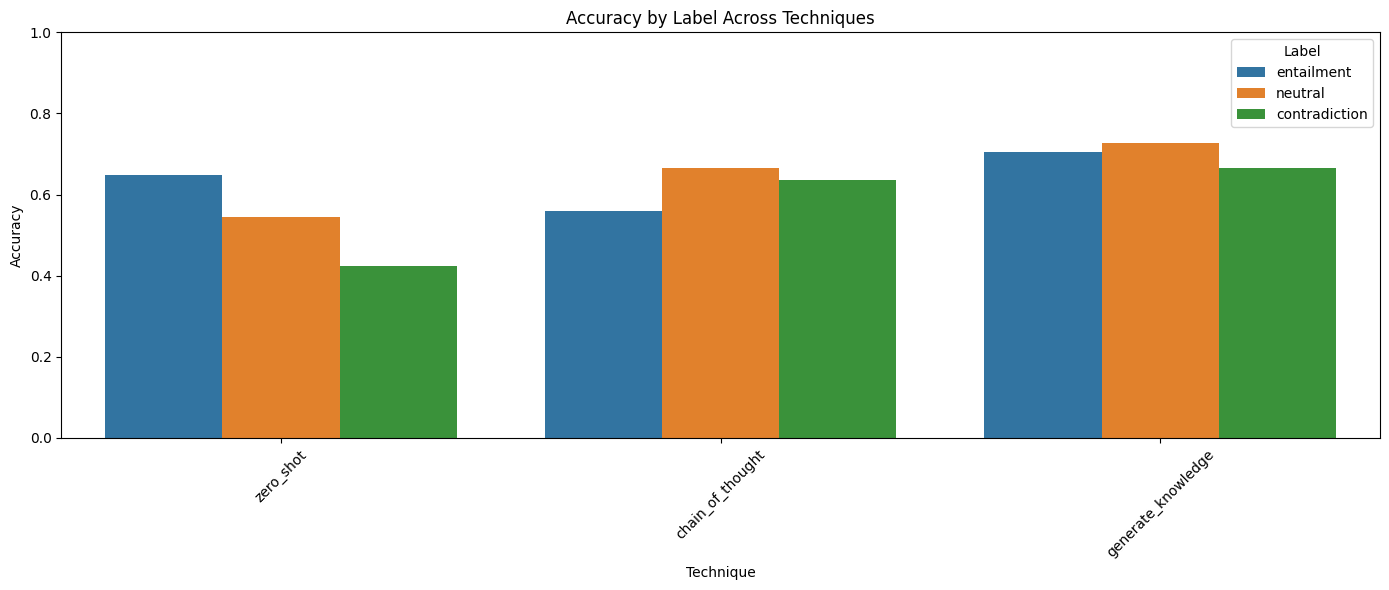

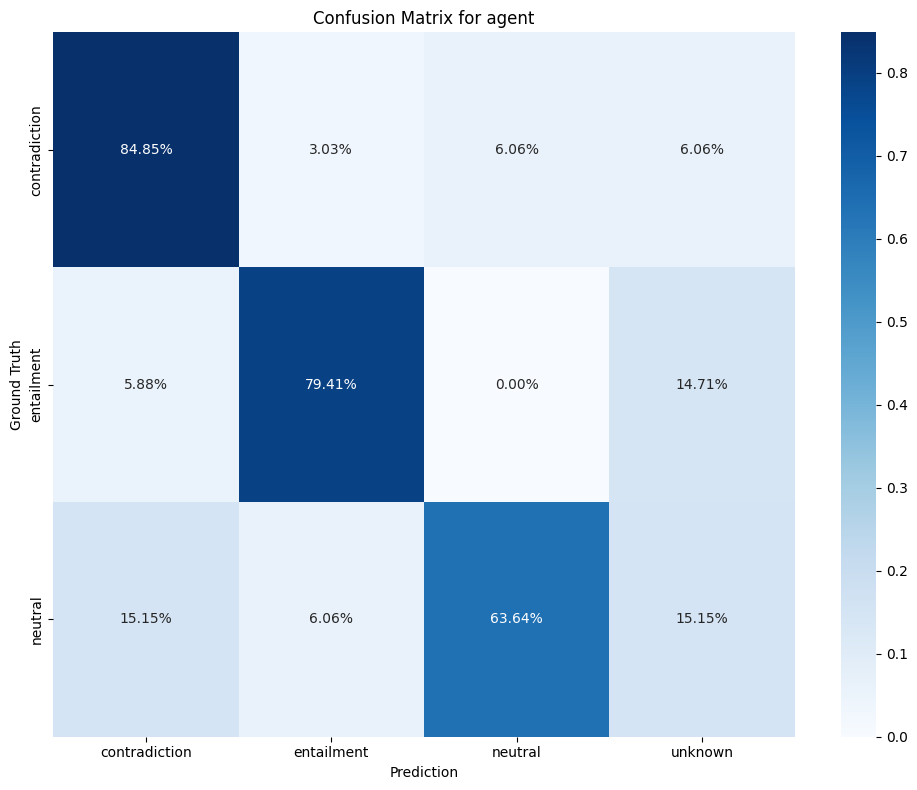

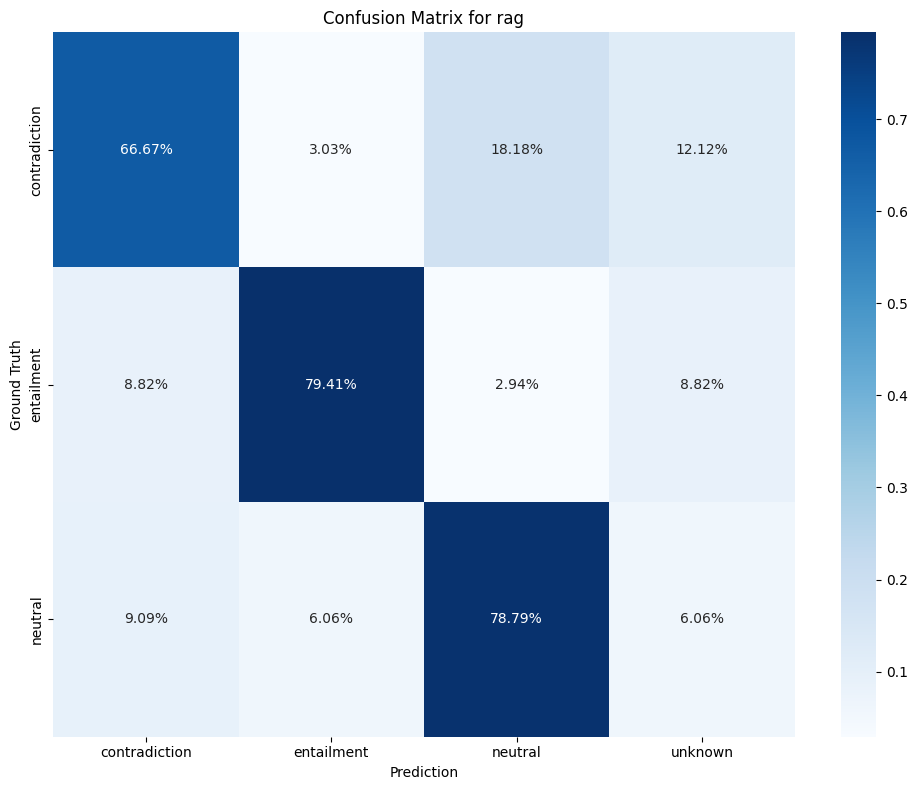

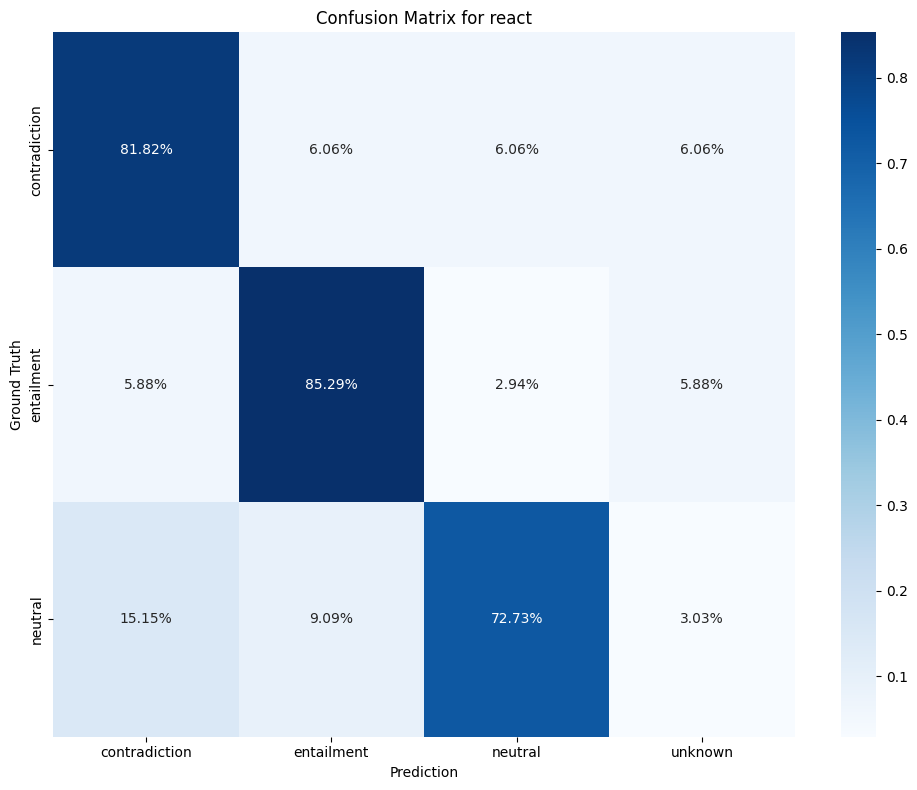

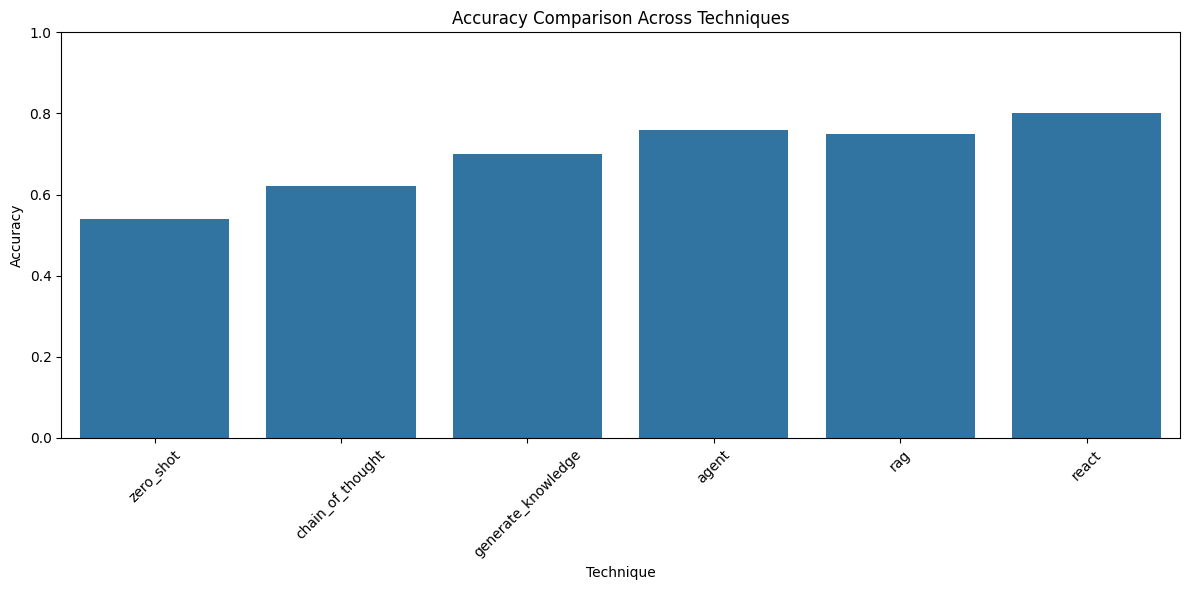

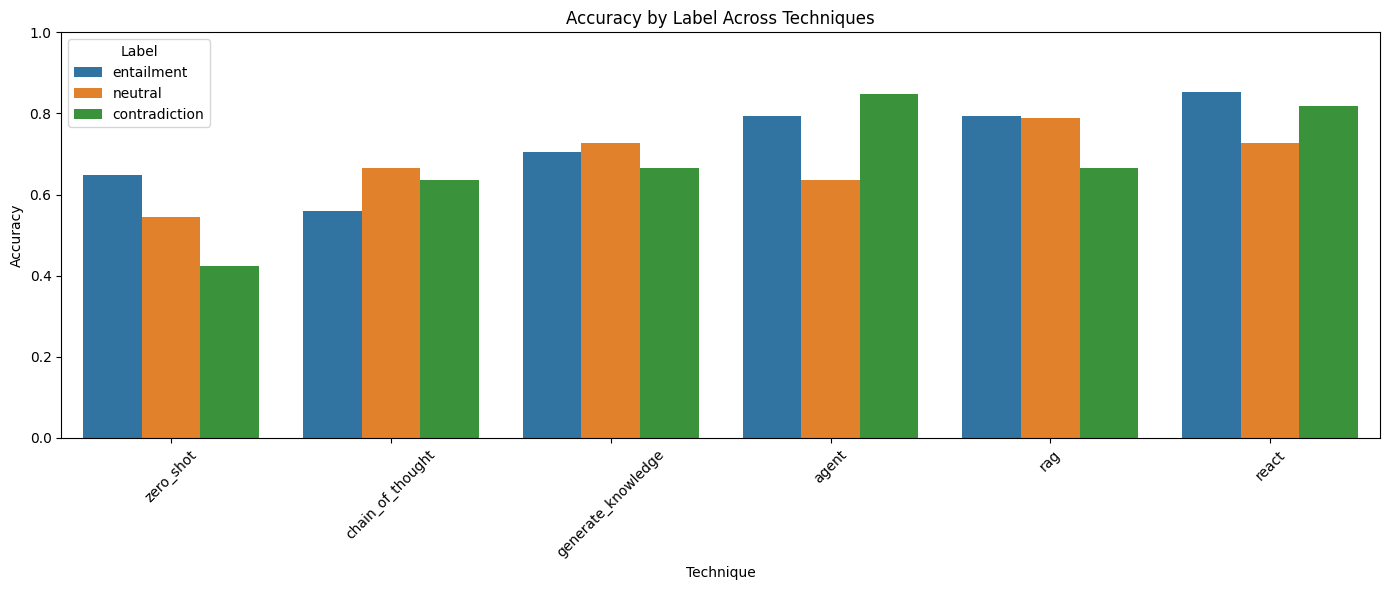

In [17]:
results, comparison, cases = run_experiment(reduced_sample_size=100)